<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/stage_2_decision/Decision%20Trees%20%2B%20No%20Shows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import optuna
from hotel_preprocessing import XYPreprocessor

Import Data

In [3]:
df = pd.read_csv("hotel_bookings.csv")

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str), errors="coerce"
)

cutoff_date = df["arrival_date"].max() - pd.DateOffset(months=3)
test_data = df[df["arrival_date"] >= cutoff_date].copy()
trainval_data = df[df["arrival_date"] < cutoff_date].copy()

X_trainval_raw = trainval_data.drop(columns=["is_canceled"])
y_trainval = trainval_data["is_canceled"]
X_test_raw = test_data.drop(columns=["is_canceled"])
y_test = test_data["is_canceled"]

Preprocess Data

In [4]:
preprocessor = XYPreprocessor()
X_trainval_transformed, y_trainval = preprocessor.fit_transform(X_trainval_raw, y_trainval)
X_test_transformed = preprocessor.transform(X_test_raw)
y_test = y_test.loc[X_test_transformed.index]
X_test_transformed = X_test_transformed.reset_index(drop=True)

Create objective function for Optuna

In [5]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.1),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in cv.split(X_trainval_transformed, y_trainval):
        X_train, X_val = X_trainval_transformed.iloc[train_idx], X_trainval_transformed.iloc[val_idx]
        y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_proba = model.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_val_proba))
    return np.mean(aucs)

Run 50 trials

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-06-21 10:17:42,697] A new study created in memory with name: no-name-696ce033-6ac3-4cbd-9959-07262c7ff4ec
[I 2025-06-21 10:17:53,114] Trial 0 finished with value: 0.5 and parameters: {'max_depth': 24, 'min_samples_split': 48, 'min_samples_leaf': 44, 'max_features': 'sqrt', 'ccp_alpha': 0.057793706783054226, 'class_weight': None}. Best is trial 0 with value: 0.5.
[I 2025-06-21 10:17:58,950] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 6, 'min_samples_split': 36, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'ccp_alpha': 0.017576430773093055, 'class_weight': None}. Best is trial 0 with value: 0.5.
[I 2025-06-21 10:18:03,988] Trial 3 finished with value: 0.5 and parameters: {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 44, 'max_features': 'sqrt', 'ccp_alpha': 0.08643888714549862, 'class_weight': None}. Best is trial 0 with value: 0.5.
[I 2025-06-21 10:18:07,375] Trial 4 finished with value: 0.5 and parameters: {'max_depth': 14, 'min_samples_spli

## Stage 1 - Predicting Cancellations via Decision Tree Classifier

In [7]:
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params, random_state=42)
final_model.fit(X_trainval_transformed, y_trainval)

DecisionTreeClassifier(ccp_alpha=7.531293633643523e-05, class_weight='balanced',
                       max_depth=25, min_samples_leaf=16, min_samples_split=11,
                       random_state=42)

In [8]:
y_test_proba = final_model.predict_proba(X_test_transformed)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)
print("Test AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test AUC: 0.8359111478669727
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      8556
           1       0.62      0.72      0.67      4679

    accuracy                           0.75     13235
   macro avg       0.73      0.74      0.73     13235
weighted avg       0.76      0.75      0.75     13235



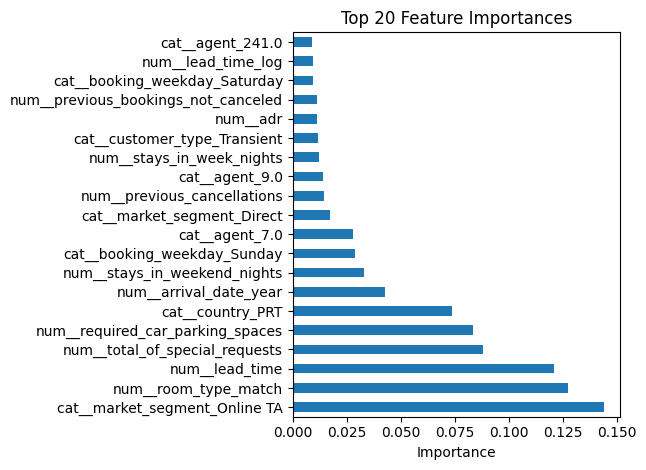

In [9]:
importances = pd.Series(final_model.feature_importances_, index=preprocessor.feature_names_)
top_importances = importances.sort_values(ascending=False).head(20)
top_importances.plot(kind="barh", title="Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

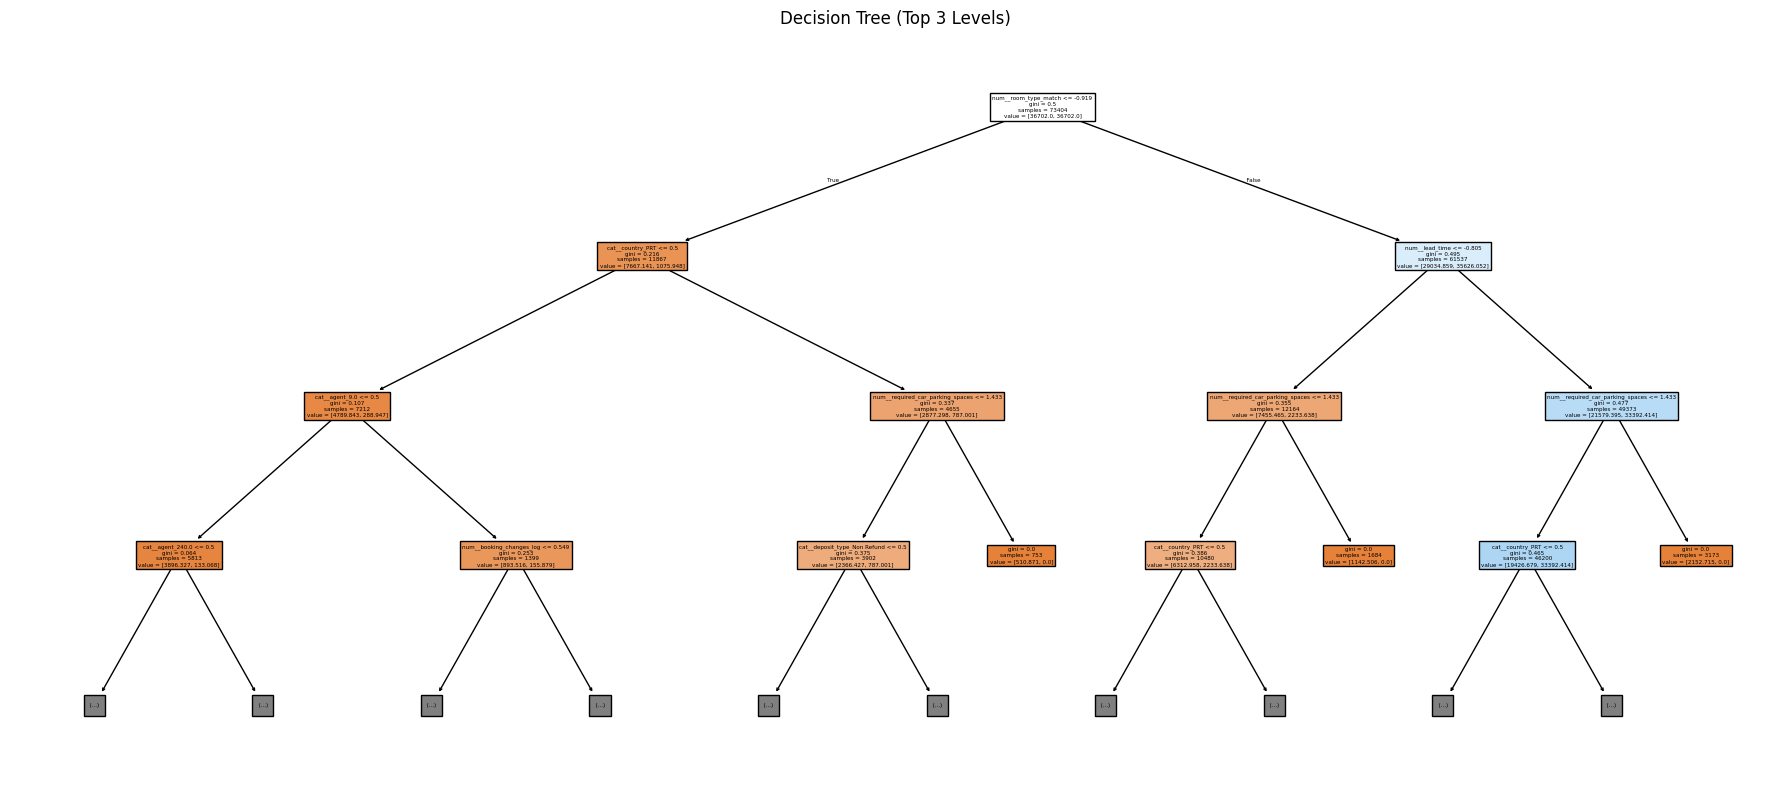

In [10]:
plt.figure(figsize=(18, 8))
plot_tree(final_model, max_depth=3, filled=True, feature_names=preprocessor.feature_names_)
plt.title("Decision Tree (Top 3 Levels)")
plt.tight_layout()
plt.show()

In [11]:
# Print Feature Importances
importances = final_model.feature_importances_
feature_names = preprocessor.feature_names_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 20 Feature Importances:")
print(feat_imp.head(20))

Top 20 Feature Importances:
cat__market_segment_Online TA          0.144137
num__room_type_match                   0.127372
num__lead_time                         0.120739
num__total_of_special_requests         0.088044
num__required_car_parking_spaces       0.083360
cat__country_PRT                       0.073646
num__arrival_date_year                 0.042853
num__stays_in_weekend_nights           0.032794
cat__booking_weekday_Sunday            0.028717
cat__agent_7.0                         0.027926
cat__market_segment_Direct             0.017323
num__previous_cancellations            0.014356
cat__agent_9.0                         0.013945
num__stays_in_week_nights              0.012095
cat__customer_type_Transient           0.011699
num__adr                               0.011402
num__previous_bookings_not_canceled    0.010942
cat__booking_weekday_Saturday          0.009275
num__lead_time_log                     0.009245
cat__agent_241.0                       0.008892
dtype: float

## Stage 2 - Predicting Late Cancellations & No Shows

In [57]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score

hotel_data = pd.read_csv("hotel_bookings.csv")

month_map = {m: i for i, m in enumerate(
    ['January','February','March','April','May','June',
     'July','August','September','October','November','December'], 1)}
hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'].map(month_map).astype(str) + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    errors='coerce'
)

df_stage2 = hotel_data[hotel_data['is_canceled'] == 1].copy()

df_stage2['room_type_match'] = (df_stage2['reserved_room_type'] == df_stage2['assigned_room_type']).astype(int)
df_stage2.drop(columns=['reserved_room_type', 'assigned_room_type'], inplace=True)

df_stage2['reservation_status_date'] = pd.to_datetime(df_stage2['reservation_status_date'], errors='coerce')
df_stage2['days_before_arrival'] = (df_stage2['arrival_date'] - df_stage2['reservation_status_date']).dt.days

df_stage2['late_cancel_or_noshow'] = (
    (df_stage2['reservation_status'] == 'No-Show') |
    ((df_stage2['reservation_status'] == 'Canceled') & (df_stage2['days_before_arrival'] <= 3))
).astype(int)

df_stage2['total_guests'] = df_stage2[['adults', 'children', 'babies']].sum(axis=1, min_count=1)
df_stage2['total_nights'] = df_stage2['stays_in_week_nights'] + df_stage2['stays_in_weekend_nights']

features_to_use = [
    'lead_time', 'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'adr',
    'required_car_parking_spaces', 'total_of_special_requests',
    'total_guests', 'total_nights', 'room_type_match',
    'hotel', 'deposit_type', 'customer_type',
    'market_segment', 'distribution_channel'
]

latest_date = df_stage2['arrival_date'].max()
test_cutoff = latest_date - pd.DateOffset(months=3)

df_trainval = df_stage2[df_stage2['arrival_date'] < test_cutoff]
df_test = df_stage2[df_stage2['arrival_date'] >= test_cutoff]

X_trainval = df_trainval[features_to_use]
y_trainval = df_trainval['late_cancel_or_noshow']
X_test = df_test[features_to_use]
y_test = df_test['late_cancel_or_noshow']

num_features = X_trainval.select_dtypes(include='number').columns.tolist()
cat_features = [f for f in features_to_use if f not in num_features]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_features)
])

pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        solver='liblinear'
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_trainval, y_trainval, cv=cv, scoring='roc_auc')
print(f"CV AUC Scores: {cv_scores}")
print(f"Mean CV AUC: {np.mean(cv_scores):.4f}")

pipe.fit(X_trainval, y_trainval)
y_test_proba = pipe.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nHold-out Test AUC: {test_auc:.4f}")

ohe = pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_expanded = ohe.get_feature_names_out(cat_features)
feature_names = num_features + cat_expanded.tolist()

coef_series = pd.Series(pipe.named_steps['clf'].coef_[0], index=feature_names)
print("\nTop + coefficients:")
print(coef_series.sort_values(ascending=False).head(10))

print("\nTop – coefficients:")
print(coef_series.sort_values().head(10))


CV AUC Scores: [0.87870692 0.85724234 0.87399946 0.86828283 0.87287388]
Mean CV AUC: 0.8702

Hold-out Test AUC: 0.8407

Top + coefficients:
deposit_type_Refundable           0.983783
distribution_channel_Direct       0.839624
market_segment_Aviation           0.835572
deposit_type_No Deposit           0.683460
market_segment_Undefined          0.302662
hotel_City Hotel                  0.236801
total_of_special_requests         0.194265
distribution_channel_Undefined    0.185670
customer_type_Group               0.183050
market_segment_Offline TA/TO      0.150956
dtype: float64

Top – coefficients:
deposit_type_Non Refund      -1.663573
lead_time                    -1.317879
distribution_channel_TA/TO   -0.876645
market_segment_Online TA     -0.615430
market_segment_Direct        -0.520250
previous_cancellations       -0.440984
room_type_match              -0.363199
customer_type_Transient      -0.285451
hotel_Resort Hotel           -0.233131
total_guests                 -0.229453
dtyp